# Multilayer Perceptron Experiments on Sine Wave

## Functions and Imports

In [1]:
import torch
torch.manual_seed(0)

import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128

device=torch.device('mps')

# for visualization of animation
from PIL import Image
from matplotlib import animation
from IPython.display import HTML

frames = 50
epochs_per_frame = 80

In [2]:
def gen_data(L=1000, reverse=False):

    x = torch.linspace(-30*torch.pi, 30*torch.pi, L)
    y = torch.sin(x)

    x_train = x[L//4: 3*L//4]
    y_train = y[L//4: 3*L//4]

    x_test = torch.concatenate([x[:L//4], x[3*L//4:]])
    y_test = torch.concatenate([y[:L//4], y[3*L//4:]])


    if reverse: # reverse train and test
        return x_test, y_test, x_train, y_train
    else:
        return x_train, y_train, x_test, y_test

In [3]:
class MLP(nn.Module):
    def __init__(self, count_hidden, count_nodes, 
                 use_batchnorm, use_xavier_normal):
        super().__init__()

        # ------------------------
        # case 1 w batch norm
        if use_batchnorm:
            self.input_layer = nn.Sequential(*[
                nn.Linear(1, count_nodes),
                nn.BatchNorm1d(count_nodes),
                nn.ReLU(inplace=True),
            ])

            self.hidden_layer = nn.Sequential(*[
                nn.Linear(count_nodes, count_nodes),
                nn.BatchNorm1d(count_nodes),
                nn.ReLU(inplace=True),
            ] * count_hidden)

        # ------------------------
        # case 2 no batch norm
        elif not use_batchnorm:
            self.input_layer = nn.Sequential(*[
                nn.Linear(1, count_nodes),
                nn.ReLU(inplace=True),
            ])

            self.hidden_layer = nn.Sequential(*[
                nn.Linear(count_nodes, count_nodes),
                nn.ReLU(inplace=True),
            ] * count_hidden)            
            
        # output
        self.output_layer = nn.Linear(count_nodes, 1)

        # apply weights        
        if use_xavier_normal:
            self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_normal_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        x = x.to(device)
        x = self.input_layer(x)
        x = self.hidden_layer(x)
        x = self.output_layer(x)
        
        return x

In [4]:
def train_model(model, epochs=1000):
    model.train()
    for k in range(epochs):

        # shuffle x_train
        inds = np.random.choice(range(len(x_train)), size=len(x_train), replace=False)

        x_inp = x_train[inds]
        y_inp = y_train[inds]

        batch_idx = np.random.choice(np.arange(0, len(x_train) - batch_size))        

        x_inp = x_inp[batch_idx : batch_idx + batch_size]
        y_inp = y_inp[batch_idx : batch_idx + batch_size]
        
        pred = model(x_inp[:, None])

        # loss
        loss = torch.mean((pred.squeeze().to("cpu") - y_inp)**2)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        scheduler.step()

        # if k%500 == 0:
        #     print("Loss:",loss.cpu().item())

    return model

In [5]:
def predict(model, x_inp):
    model.eval()
    ypred = model(x_inp[:, None])
    return ypred.cpu().detach().numpy()

In [6]:
def compute_mse(y_pred, y_true):
    return np.mean((np.array(y_true) - y_pred)**2)

In [7]:
def visualize(model, axs, title):

    y_pred_train = predict(model, x_train).squeeze()
    y_pred_test = predict(model, x_test).squeeze()

    mse_train = np.around(compute_mse(y_pred_train, y_train), 2)
    mse_test = np.around(compute_mse(y_pred_test, y_test), 2)
    
    axs.scatter(x_train, y_pred_train, s=1, marker='o', label='train')
    axs.scatter(x_test, y_pred_test, s=1, marker='o', label='test')

    axs.plot(x_train, y_train, alpha=0.1)
    # axs.scatter(x_test, y_test, s=1, alpha=0.1)
    axs.set_ylim(-1.5, 1.5)

    # axs.legend()
    title = title + f" | MSE train: {str(mse_train).zfill(2)} | MSE test: {str(mse_test).zfill(2)}"
    axs.set_title(title)
    axs.spines[['right', 'top']].set_visible(False)
    # plt.tight_layout()

In [8]:
def animate(iter):
    global model 

    epochs = epochs_per_frame
    model = train_model(model, epochs=epochs)    
    
    axs.clear()

    title = f"Hidden layers: {count_hidden} | Nodes: {count_nodes} | Training Epoch {str(epochs * iter).zfill(4)}"
    visualize(model, axs, title)

    return None

## Extrapolation Experiment

We generated synthetic data using sin(x) function, which we aim to learn. The blue colors are the training set which we will use to train our model. The orange colors are the test set which we will use to check if our model can generalize and did learn the sine function

Our inputs are the x-values (horizontal axis) and our targets are y = sin(x), which we will train our model to predict given x.

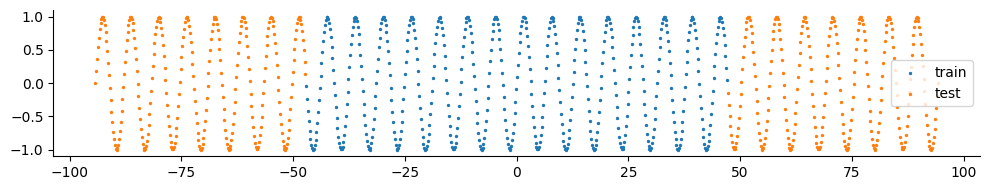

In [9]:
x_train, y_train, x_test, y_test = gen_data(reverse=False)

fig, axs = plt.subplots(1, 1, figsize=(10, 2))
plt.scatter(x_train, y_train, label='train', s=2)
plt.scatter(x_test, y_test, label='test', s=2)
plt.legend()
plt.tight_layout()
axs.spines[['right', 'top']].set_visible(False)

We show an animation below of the neural network parameters (MLP) and the evolution of how it fits the data over its training (epochs).
We experimented on different model complexities and see how they fit the data and generalize over the test set.

We find that as the number of nodes per layer increases, while maintaing two-layers, the ability of the model improves, then peaks at a certain number of nodes, and actually worsens. Why is this the case?

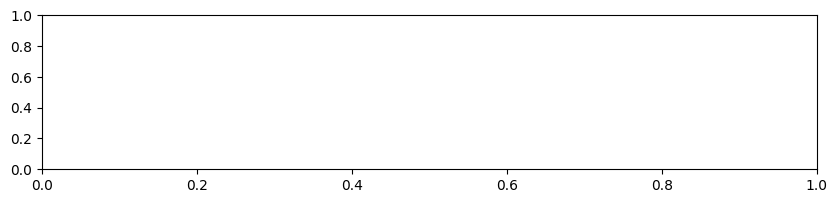

In [10]:
# for animation
fig, axs = plt.subplots(1, 1, figsize=(10, 2)) # dpi=200)

In [11]:
count_hidden = 2
count_nodes = 4
use_batchnorm = True
use_xavier_normal = True
batch_size = len(x_train) - 1

model = MLP(count_hidden=count_hidden, count_nodes=count_nodes, 
            use_batchnorm=use_batchnorm, use_xavier_normal=use_xavier_normal)
model = model.to(device)
optim = torch.optim.Adam(model.parameters(),lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size= 1000)

anim = animation.FuncAnimation(fig,
                               animate, 
                               frames=frames, 
                               interval=1)
HTML(anim.to_jshtml(fps=30))

We find that it seems that the model only learns to fit some parts of the middle of the sine wave. What if we increase the number of nodes.

In [12]:
count_hidden = 2
count_nodes = 8
use_batchnorm = True
use_xavier_normal = True
batch_size = len(x_train) - 1

model = MLP(count_hidden=count_hidden, count_nodes=count_nodes, 
            use_batchnorm=use_batchnorm, use_xavier_normal=use_xavier_normal)
model = model.to(device)
optim = torch.optim.Adam(model.parameters(),lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size= 1000)

anim = animation.FuncAnimation(fig, 
                               animate, 
                               frames=frames, 
                               interval=1)
HTML(anim.to_jshtml(fps=30))

In [ ]:
count_hidden = 2
count_nodes = 16
use_batchnorm = True
use_xavier_normal = True
batch_size = len(x_train) - 1

model = MLP(count_hidden=count_hidden, count_nodes=count_nodes, 
            use_batchnorm=use_batchnorm, use_xavier_normal=use_xavier_normal)
model = model.to(device)
optim = torch.optim.Adam(model.parameters(),lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size= 1000)

anim = animation.FuncAnimation(fig, 
                               animate, 
                               frames=frames, 
                               interval=1)
HTML(anim.to_jshtml(fps=30))

In [ ]:
count_hidden = 2
count_nodes = 32
use_batchnorm = True
use_xavier_normal = True
batch_size = len(x_train) - 1

model = MLP(count_hidden=count_hidden, count_nodes=count_nodes, 
            use_batchnorm=use_batchnorm, use_xavier_normal=use_xavier_normal)
model = model.to(device)
optim = torch.optim.Adam(model.parameters(),lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size= 1000)

anim = animation.FuncAnimation(fig,
                               animate,
                               frames=frames, 
                               interval=1)
HTML(anim.to_jshtml(fps=30))

In [ ]:
count_hidden = 2
count_nodes = 64
use_batchnorm = True
use_xavier_normal = True
batch_size = len(x_train) - 1

model = MLP(count_hidden=count_hidden, count_nodes=count_nodes, 
            use_batchnorm=use_batchnorm, use_xavier_normal=use_xavier_normal)
model = model.to(device)
optim = torch.optim.Adam(model.parameters(),lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size= 1000)

anim = animation.FuncAnimation(fig,
                               animate,
                               frames=frames, 
                               interval=1)
HTML(anim.to_jshtml(fps=30))

In [ ]:
count_hidden = 2
count_nodes = 128
use_batchnorm = True
use_xavier_normal = True
batch_size = len(x_train) - 1

model = MLP(count_hidden=count_hidden, count_nodes=count_nodes, 
            use_batchnorm=use_batchnorm, use_xavier_normal=use_xavier_normal)
model = model.to(device)
optim = torch.optim.Adam(model.parameters(),lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size= 1000)

anim = animation.FuncAnimation(fig,
                               animate,
                               frames=frames, 
                               interval=1)
HTML(anim.to_jshtml(fps=30))

In [ ]:
count_hidden = 2
count_nodes = 256
use_batchnorm = True
use_xavier_normal = True
batch_size = len(x_train) - 1

model = MLP(count_hidden=count_hidden, count_nodes=count_nodes, 
            use_batchnorm=use_batchnorm, use_xavier_normal=use_xavier_normal)
model = model.to(device)
optim = torch.optim.Adam(model.parameters(),lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size= 1000)

anim = animation.FuncAnimation(fig,
                               animate,
                               frames=frames, 
                               interval=1)
HTML(anim.to_jshtml(fps=30))

In [ ]:
count_hidden = 2
count_nodes = 512
use_batchnorm = True
use_xavier_normal = True
batch_size = len(x_train) - 1

model = MLP(count_hidden=count_hidden, count_nodes=count_nodes, 
            use_batchnorm=use_batchnorm, use_xavier_normal=use_xavier_normal)
model = model.to(device)
optim = torch.optim.Adam(model.parameters(),lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size= 1000)

anim = animation.FuncAnimation(fig,
                               animate,
                               frames=frames, 
                               interval=1)
HTML(anim.to_jshtml(fps=30))

In [ ]:
count_hidden = 2
count_nodes = 1024
use_batchnorm = True
use_xavier_normal = True
batch_size = len(x_train) - 1

model = MLP(count_hidden=count_hidden, count_nodes=count_nodes, 
            use_batchnorm=use_batchnorm, use_xavier_normal=use_xavier_normal)
model = model.to(device)
optim = torch.optim.Adam(model.parameters(),lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size= 1000)

anim = animation.FuncAnimation(fig,
                               animate,
                               frames=frames, 
                               interval=1)
HTML(anim.to_jshtml(fps=30))

## Extrapolation Experiment

Now what if we make this an interpolation problem instead of an extrapolation problem. In other words, what if we reverse the train and test set? Will the model be able to infer the sine wave in between the test data? We show below the sine wave colored by train (blue) and test (orange)

In [ ]:
x_train, y_train, x_test, y_test = gen_data(reverse=True)

fig, axs = plt.subplots(1, 1, figsize=(10, 2))
plt.scatter(x_train, y_train, label='train', s=2)
plt.scatter(x_test, y_test, label='test', s=2)
plt.legend()
plt.tight_layout()
axs.spines[['right', 'top']].set_visible(False)

We applied the best architecture from our experiments above and fit on this new dataset

In [ ]:
# for animation
fig, axs = plt.subplots(1, 1, figsize=(10, 2)) # dpi=200)

In [ ]:
count_hidden = 2
count_nodes = 256
use_batchnorm = True
use_xavier_normal = True

model = MLP(count_hidden=count_hidden, count_nodes=count_nodes, 
            use_batchnorm=use_batchnorm, use_xavier_normal=use_xavier_normal)
model = model.to(device)
optim = torch.optim.Adam(model.parameters(),lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size= 1000)

anim = animation.FuncAnimation(fig, 
                               animate, 
                               frames=frames, 
                               interval=1)
HTML(anim.to_jshtml(fps=30))

Sadly, it didn't fit the training set well. So we experiment on the model complexity.

Manually tweaking the number of nodes and hidden layers is rather tedious. So for the extrapolation experiment, instead of experimenting on combinations of hyperparameters manually, we automate this via grid-search and keep track of the mean squared error per combination

In [ ]:
count_hidden_layers_range = np.arange(2, 10, 1)[:3]
count_nodes_range = [2**i for i in np.arange(2, 10)][:3]

print(count_hidden_layers_range)
print(count_nodes_range)

mse_mtx_train = np.ones((len(count_hidden_layers_range), len(count_nodes_range))) * 999
mse_mtx_test = np.ones((len(count_hidden_layers_range), len(count_nodes_range))) * 999
plt.imshow(mse_mtx_train)
plt.yticks(range(len(count_hidden_layers_range)), count_hidden_layers_range)
plt.xticks(range(len(count_nodes_range)), count_nodes_range);

In [ ]:
for i in range(len((count_hidden_layers_range))):
    for j in range(len(count_nodes_range)):

        count_hidden = count_hidden_layers_range[i]
        count_nodes = count_nodes_range[j]
        use_batchnorm = True
        use_xavier_normal = True

        model = MLP(count_hidden=count_hidden, count_nodes=count_nodes, 
                    use_batchnorm=use_batchnorm, use_xavier_normal=use_xavier_normal)
        model = model.to(device)
        optim = torch.optim.Adam(model.parameters(),lr=0.01)
        scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size= 1000)

        # train
        model = train_model(model, epochs=500)

        y_pred_train = predict(model, x_train).squeeze()
        y_pred_test = predict(model, x_test).squeeze()

        mse_train = compute_mse(y_pred_train, y_train)
        mse_test = compute_mse(y_pred_test, y_test)

        mse_mtx_train[i, j] = mse_train
        mse_mtx_test[i, j] = mse_test  

        print(count_hidden, count_nodes, np.around(mse_train, 2), np.around(mse_test, 2))      

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(np.log(mse_mtx_train), cmap='Blues')
axs[0].set_yticks(range(len(count_hidden_layers_range)), count_hidden_layers_range)
axs[0].set_xticks(range(len(count_nodes_range)), count_nodes_range)
axs[0].set_xlabel("count nodes per hidden layer")
axs[0].set_ylabel("count hidden layers")
axs[0].set_title("Train set Mean Squared Error")

axs[1].imshow(np.log(mse_mtx_test), cmap='Blues')
axs[1].set_yticks(range(len(count_hidden_layers_range)), count_hidden_layers_range)
axs[1].set_xticks(range(len(count_nodes_range)), count_nodes_range)
axs[1].set_xlabel("count nodes per hidden layer")
axs[1].set_ylabel("count hidden layers")
axs[1].set_title("Test set Mean Squared Error")

plt.tight_layout()
plt.show()

In [ ]:
# for animation
fig, axs = plt.subplots(1, 1, figsize=(10, 2)) # dpi=200)

Below is the found best model for fitting the training set.

In [ ]:
# get best hyperparam for train
count_hidden_idx, count_nodes_idx = np.argwhere(mse_mtx_train == mse_mtx_train.min())[0]
count_hidden = count_hidden_layers_range[count_hidden_idx]
count_nodes = count_nodes_range[count_nodes_idx]

use_batchnorm = True
use_xavier_normal = True

model = MLP(count_hidden=count_hidden, count_nodes=count_nodes, 
            use_batchnorm=use_batchnorm, use_xavier_normal=use_xavier_normal)
model = model.to(device)
optim = torch.optim.Adam(model.parameters(),lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size= 1000)

anim = animation.FuncAnimation(fig,
                               animate,
                               frames=frames,
                               interval=1)
HTML(anim.to_jshtml(fps=30))

Below is the best found model for generalizing on the test set

In [ ]:
# get best hyperparam for test
count_hidden_idx, count_nodes_idx = np.argwhere(mse_mtx_test == mse_mtx_test.min())[0]
count_hidden = count_hidden_layers_range[count_hidden_idx]
count_nodes = count_nodes_range[count_nodes_idx]

use_batchnorm = True
use_xavier_normal = True

model = MLP(count_hidden=count_hidden, count_nodes=count_nodes, 
            use_batchnorm=use_batchnorm, use_xavier_normal=use_xavier_normal)
model = model.to(device)
optim = torch.optim.Adam(model.parameters(),lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size= 1000)

anim = animation.FuncAnimation(fig, 
                               animate, 
                               frames=frames, 
                               interval=1)
HTML(anim.to_jshtml(fps=30))

## Take-aways

While I was initially surprised with the results on the extrapolation problem, I realized that making this highly unbiased MLP model generalize a sine function may be quite hard since there are an infinite possible functions that fit the same training set. There is no rule that tells the model that it has to extend the periodicity infinitely in both directions. In fact, this fitted model is just as valid as any of the functions that fit the data, from the perspective of the model.

In other words, we will need to incorporate our assumption that the periodicity extends infinitely, by introducing some inductive bias into the model, such that it is encouraged to find solutions that have periodicity.

With regards to interpolation, it's quite interesting that the model needs to be much more complex than for the extrapolation problem just to fit the training data. Why is this the case? 

My observation in the extrapolation problem is that the predicted sine wave seems to "propagate" outwards starting from the middle. Given this, is it possible that the interpolation problem requires a more complex model in order to propagate farther into the peripheries of the sine wave?

Still, watching how the neural network learns to fit on the training data is quite fun!

## Acknowledgements

Thanks Daniel Stanley Tan for the reference code. Thanks Kisko Apeles for the idea to interpolate the sine wave.